# Projet ARF Inpainting

# BEROUKHIM Keyvan

## Préambule

In [1]:
import sklearn.linear_model
from sklearn.metrics import accuracy_score
import numpy as np
from utils import *

In [2]:
import sys
del sys.modules['utils']
from utils import *

In [3]:
def load_usps(filename):
    with open(filename, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)

def keep_two(x, y, c0, c1):
    ind_kept = np.where((y==c0) | (y==c1))[0]
    return x[ind_kept], np.array([-1 if e==0 else 1 for e in y[ind_kept]])

In [4]:
c0 = 0
c1 = 1

In [5]:
train_x, train_y = keep_two(*load_usps("USPS_train.txt"), c0, c1)
test_x , test_y  = keep_two(*load_usps("USPS_test.txt" ), c0, c1)

In [6]:
models = [
    sklearn.linear_model.LinearRegression(),
    sklearn.linear_model.Ridge(alpha=.5),
    sklearn.linear_model.Lasso(alpha=.001)
]

In [7]:
for i, m in enumerate(models):
    print("régularisation", i)
    m.fit(train_x, train_y)
    print("précision train", accuracy_score(np.sign(m.predict(train_x)), train_y))
    print("précision test", accuracy_score(np.sign(m.predict(test_x)), test_y))
    print("nb poids non nuls", np.nonzero(m.coef_)[0].size)
    print()

régularisation 0
précision train 1.0
précision test 0.9839486356340289
nb poids non nuls 255

régularisation 1
précision train 1.0
précision test 0.9871589085072231
nb poids non nuls 254

régularisation 2
précision train 0.9995452478399273
précision test 0.9903691813804173
nb poids non nuls 97



## La méthode lasso minimise la somme des poids utilisés, le nombre de poids non nuls est plus faible qu'avec MSE mais ce n'est pas équivalent à minimiser le nombre de poids non nuls : Le modèle préfère expliquer les patchs par des patchs avec des coefficients plus forts (plus clairs en RGB) afin d'utiliser des poids faibles.

image (61, 80, 3) nb pixels 4880


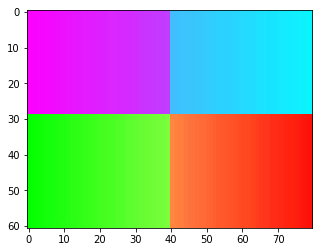

In [8]:
im = read_im("degrade2_petit.png")
print("image", im.shape, "nb pixels", im.size // 3)
print_im(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nb à reconstruire 48
loss 7.464517e-07


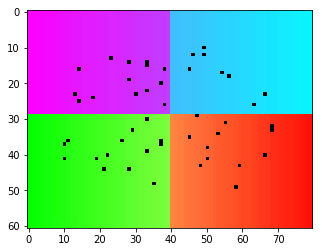

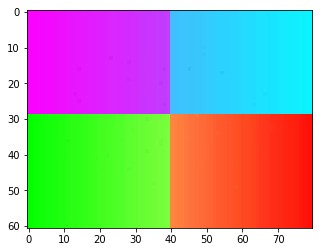

In [9]:
p = .01
bruitee = noise(im, p)
print("nb à reconstruire", int(im.size // 3 * p))
print_im(bruitee)
undo_noise(bruitee, alpha=.001, max_iter=10000)
print_im(bruitee)
print("loss", np.mean(np.power(im - bruitee, 2)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nb à reconstruire 242


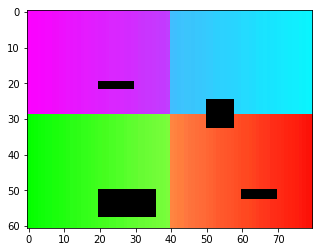

In [10]:
rectangles = [
    (20,20,2,10),
    (50,20,8,16),
    (25,50,8,8),
    (50,60,3,10),
]
bruitee = im
for r in rectangles:
    bruitee = delete_rec(bruitee,r)
print("nb à reconstruire", sum(r[2]*r[3] for r in rectangles))
print_im(bruitee)


loss 0.00023898356


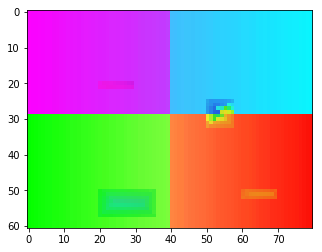

In [11]:
reconstruite = bruitee.copy()
for r in rectangles:
    undo_rect(reconstruite, r, w=3, alpha=.01, max_iter=10000)
print_im(reconstruite)
print("loss", np.mean(np.power(im - reconstruite, 2)))
plt.show()

### Sur des images simples, la méthode marche relativement bien pour des points mais pas pour des plus grandes zones
### Minimiser le nombre de patchs utilisés est un problème difficile. On améliore la méthode précédente de la manière suivante: pour chaque pixel à restorer, on essaye de trouver un patch complet qui explique à lui seul le patch à compléter, sinon on utilise la méthode du lasso.
### On pourrait ensuite essayer avec plusieurs patchs, mais la complexité est exponentielle en le nombre de patch. 

loss 6.275941e-05


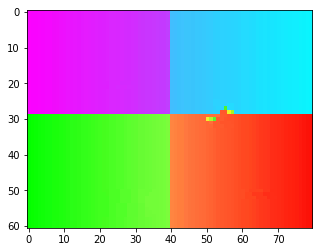

In [12]:
reconstruite = bruitee.copy()
for r in rectangles:
    undo_rect(reconstruite, r, w=3, alpha=.01, max_iter=10000, threshOS=.01)
print_im(reconstruite)
print("loss", np.mean(np.power(im - reconstruite, 2)))
plt.show()

image (33, 112, 3) nb pixels 3696


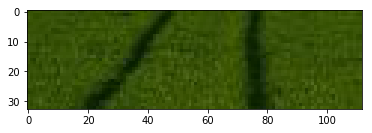

In [13]:
im = read_im("herbe.jpeg")
print("image", im.shape, "nb pixels", im.size // 3)
print_im(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nb à reconstruire 130


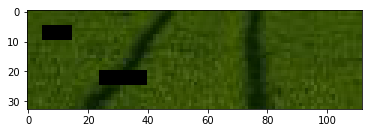

In [14]:
rectangles = [(5,5,5,10), (20,24,5,16)]
bruitee = im
for r in rectangles:
    bruitee = delete_rec(bruitee,r)
print("nb à reconstruire", sum(r[2]*r[3] for r in rectangles))
print_im(bruitee)

loss 0.0001740105182890624


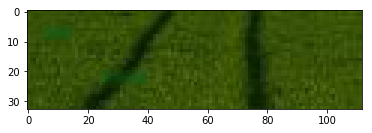

loss 0.00014686000070227828


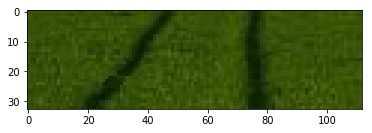

In [15]:
reconstruite = bruitee.copy()
for i, r in enumerate(rectangles):
    undo_rect(reconstruite, r, w=3, alpha=.01, max_iter=10000)
print_im(reconstruite)
print("loss", np.mean(np.power(im - reconstruite, 2)))
plt.show()

reconstruite = bruitee.copy()
for i, r in enumerate(rectangles):
    undo_rect(reconstruite, r, w=3, alpha=.01, max_iter=10000, threshOS=.01)
print_im(reconstruite)
print("loss", np.mean(np.power(im - reconstruite, 2)))
plt.show()

### La solution trouvée est plus efficace que la solution de base et elle est aussi plus rapide à exécuter.